In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
#Set up data transform. Used to convert data into tensor
transform = transforms.ToTensor()

In [3]:
#download data set
train_dataset = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

100%|██████████| 9.91M/9.91M [00:11<00:00, 893kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 59.0kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.44MB/s]


In [4]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [5]:
#Create Dataloader

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [6]:
images, labels = next(iter(train_loader))
print(images.shape)
print(labels.shape)

torch.Size([128, 1, 28, 28])
torch.Size([128])


In [7]:
images[0].shape

torch.Size([1, 28, 28])

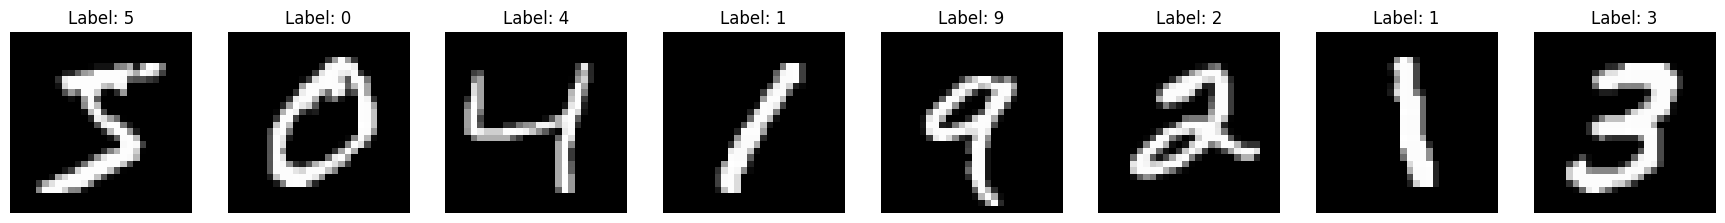

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(22,10))
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f"Label: {labels[i]}")
    plt.axis("off")

plt.show()

In [9]:
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()

        #encoder block
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, hidden_dim),
            nn.ReLU()
        )

        #decoder block
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim),
            nn.Sigmoid() # apply the sigmoid activation function to compress the output to a range of (0, 1)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [10]:
#Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim, hidden_dim, output_dim = 784, 16, 784

model = Autoencoder(input_dim, hidden_dim, output_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

criterion = nn.BCELoss()
model.to(device)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=16, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=784, bias=True)
    (3): Sigmoid()
  )
)

In [ ]:
epochs = 100

for epoch in range(epochs):
    running_loss = 0.0
    for batch_x, _ in train_loader:
        batch_x = batch_x.to(device)

        #Reshape torch.Size([64, 1, 28, 28]) to torch.Size([64, 784])
        batch_x = batch_x.reshape(batch_x.shape[0], -1)

        #Forward pass
        encoded, decoded = model(batch_x)

        #loss calculation
        loss = criterion(decoded, batch_x)
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * batch_x.size(0) 

    epoch_loss = running_loss / len(train_loader.dataset) 
    if (epoch+1)%10==0:
        print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f}")


Epoch 10/100 - Loss: 0.1003
Epoch 20/100 - Loss: 0.0984
Epoch 30/100 - Loss: 0.0972
Epoch 40/100 - Loss: 0.0964
Epoch 50/100 - Loss: 0.0957
Epoch 60/100 - Loss: 0.0952
Epoch 70/100 - Loss: 0.0948
Epoch 80/100 - Loss: 0.0944
Epoch 90/100 - Loss: 0.0942
Epoch 100/100 - Loss: 0.0939


In [18]:
batch_x, _ = next(iter(test_loader))
batch_x = batch_x.to(device)

batch_x = batch_x.reshape(batch_x.shape[0], -1)

with torch.no_grad():
    encoded, decoded = model(batch_x[:10])


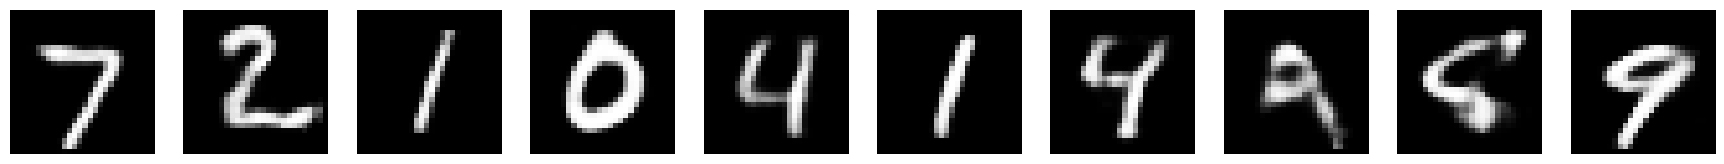

In [ ]:
#Reconstructed images
plt.figure(figsize=(22,10))
i = 1
decoded_cpu = decoded.cpu()
for decoded_img in decoded_cpu:
    plt.subplot(1,10,i)
    plt.imshow(decoded_img.reshape(28,28), cmap='gray')
    plt.axis('off')

    i+=1
plt.show()

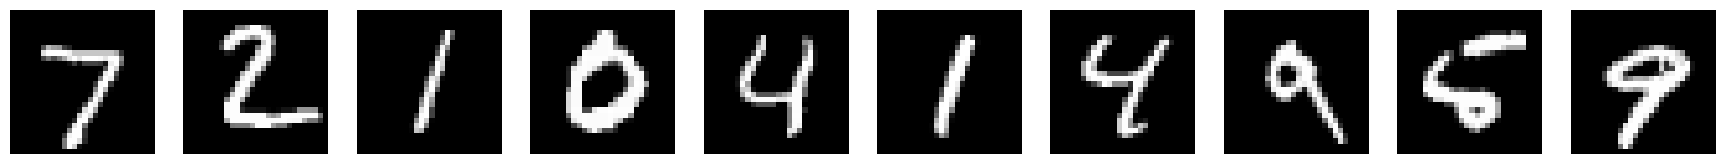

In [ ]:
#True images
plt.figure(figsize=(22,10))
i = 1
true_image = batch_x[:10].cpu()
for img in true_image:
    plt.subplot(1,10,i)
    plt.imshow(img.reshape(28,28), cmap='gray')
    plt.axis('off')

    i+=1
plt.show()